In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM

In [8]:
PGHOST = 'stocksdb.cndg3gmolxwq.us-east-1.rds.amazonaws.com'
PGDATABASE = 'postgres'
PGUSER = 'root'
PGPASSWORD = 'team122022'


def connect():
    
    # Set up a connection to the postgres server.
    conn_string = "host="+PGHOST +" port="+ "5432" +" dbname="+PGDATABASE +" user=" + PGUSER \
                  +" password="+ PGPASSWORD
    
    conn = psycopg2.connect(conn_string)
    print("Connected!")

    # Create a cursor object
    cursor = conn.cursor()
    
    return conn, cursor

In [10]:
conn, cursor = connect()

Connected!


In [ ]:
stock_data = """
    SELECT * FROM stockmerged
"""

In [12]:
# Get the data, read csv file into data frame
df = pd.read_csv("AAPL.csv")
df.head(31)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100039,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094820,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087861,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090035,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092646,73449600
5,1980-12-19,0.126116,0.126674,0.126116,0.126116,0.098300,48630400
6,1980-12-22,0.132254,0.132813,0.132254,0.132254,0.103084,37363200
7,1980-12-23,0.137835,0.138393,0.137835,0.137835,0.107434,46950400
8,1980-12-24,0.145089,0.145647,0.145089,0.145089,0.113088,48003200
9,1980-12-26,0.158482,0.159040,0.158482,0.158482,0.123527,55574400


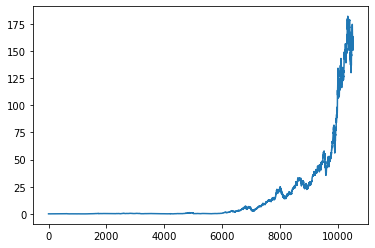

In [4]:
# Vistulize the input data frame
plt.plot(df['Close'])
plt.show()

In [5]:
# Choose "Closed" price column as our input variable
close_df= df['Close']
close_df_train = close_df.loc[close_df.index < len(close_df)*0.8]
close_df_test = close_df.loc[close_df.index >= len(close_df)*0.8]

print(close_df_train.head())
print()
print(close_df_test.head())

0    0.128348
1    0.121652
2    0.112723
3    0.115513
4    0.118862
Name: Close, dtype: float64

8425    20.912144
8426    21.172501
8427    21.205713
8428    21.209642
8429    21.029285
Name: Close, dtype: float64


In [6]:
# Scale the training data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_df_train.values.reshape(-1,1))
scaled_data.shape

(8425, 1)

In [7]:
# Use the previous 30 days 'close' price to predict the 31st day's price
previous_days = 30

In [13]:
# Splite data into X_train and y_train
X_train = []
y_train = []

for i in range(previous_days, len(scaled_data)):
    X_train.append(scaled_data[i-previous_days:i, 0])
    y_train.append(scaled_data[i, 0])
    
    if i<=previous_days+1:
        print(X_train)
        print(y_train)

[array([0.00316636, 0.0028988 , 0.00254201, 0.00265349, 0.00278731,
       0.00307717, 0.00332244, 0.00354545, 0.00383531, 0.00437047,
       0.00445966, 0.00430358, 0.00412521, 0.0041921 , 0.00405832,
       0.00379071, 0.00354545, 0.00343396, 0.00372382, 0.00367923,
       0.00347856, 0.00350085, 0.00361234, 0.00356774, 0.0039022 ,
       0.00372382, 0.00383531, 0.0039022 , 0.0038799 , 0.00379071])]
[0.00374611991883287]
[array([0.00316636, 0.0028988 , 0.00254201, 0.00265349, 0.00278731,
       0.00307717, 0.00332244, 0.00354545, 0.00383531, 0.00437047,
       0.00445966, 0.00430358, 0.00412521, 0.0041921 , 0.00405832,
       0.00379071, 0.00354545, 0.00343396, 0.00372382, 0.00367923,
       0.00347856, 0.00350085, 0.00361234, 0.00356774, 0.0039022 ,
       0.00372382, 0.00383531, 0.0039022 , 0.0038799 , 0.00379071]), array([0.0028988 , 0.00254201, 0.00265349, 0.00278731, 0.00307717,
       0.00332244, 0.00354545, 0.00383531, 0.00437047, 0.00445966,
       0.00430358, 0.00412521, 0.0

In [100]:
# Convert the X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(8365, 60, 1)
(8365,)


In [75]:
# Reshape the X_train since LSTM needs 3-dimensional inputs
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(8365, 60, 1)

In [76]:
# Build the LSTM model
model = Sequential()
# Add LSTM layer
model.add(LSTM(units = 50, return_sequences=True, input_shape = (X_train.shape[1],1)))
model.add(LSTM(units = 50))
# prediction output layer
model.add(Dense(units=1))

In [77]:
# compile and train the data
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size =100, epochs=20)

Epoch 1/20
84/84 [==============================] - 10s 68ms/step - loss: 0.0040
Epoch 2/20
84/84 [==============================] - 6s 70ms/step - loss: 1.1894e-04
Epoch 3/20
84/84 [==============================] - 6s 71ms/step - loss: 1.1103e-04
Epoch 4/20
84/84 [==============================] - 6s 71ms/step - loss: 1.0729e-04
Epoch 5/20
84/84 [==============================] - 6s 69ms/step - loss: 1.0521e-04
Epoch 6/20
84/84 [==============================] - 6s 71ms/step - loss: 1.0719e-04
Epoch 7/20
84/84 [==============================] - 6s 72ms/step - loss: 9.7802e-05
Epoch 8/20
84/84 [==============================] - 6s 72ms/step - loss: 8.4433e-05
Epoch 9/20
84/84 [==============================] - 6s 70ms/step - loss: 1.1608e-04
Epoch 10/20
84/84 [==============================] - 6s 71ms/step - loss: 8.4419e-05
Epoch 11/20
84/84 [==============================] - 6s 71ms/step - loss: 8.1992e-05
Epoch 12/20
84/84 [==============================] - 6s 70ms/step - loss: 7.8

In [78]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_4 (LSTM)               (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [81]:
#### Test model ####

# Scale the testing data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_test_data = scaler.fit_transform(close_df_test.values.reshape(-1,1))
scaled_test_data.shape

(2106, 1)

In [82]:
# Create X_test and y_test
X_test = []
y_test = []

for i in range(previous_days, len(scaled_test_data)):
    X_test.append(scaled_test_data[i-previous_days:i, 0])
    y_test.append(scaled_test_data[i, 0])

In [83]:
# Convert the X_test and y_test to numpy arrays
X_test = np.array(X_test)
print(X_test.shape)

(2046, 60)


In [84]:
# reshape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_test.shape)

(2046, 60, 1)


In [87]:
# Predict the data

prediction = model.predict(X_test)
prediction = scaler.inverse_transform(predictions)

64/64 [==============================] - 1s 12ms/step


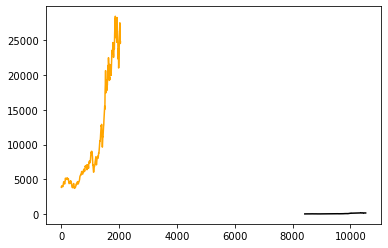

In [106]:
# plot test predictions

plt.plot(prediction, color = 'orange')
plt.plot(close_df_test, color = 'black')
plt.show()